In [1]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')

from model import ode_y, ode_y_parallel
from simulation import simulation
from utilities import find_nearest_value, compute_derivatives
from solver import false_transient_one_iteration_python
from numba import njit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

## Solve HJB

In [10]:
# Intensity parameter
τ = 1.

r1 = 19.5001
r0 = .25

# Robustness parameters
ξ_w = 100000.
ξ_p = 5.
ξ_a = 1./100

n_model = 20
damage_setting={'γ_2p': np.linspace(0, .3853*2, n_model),
                'πd_o': np.ones(n_model)/n_model}

# Model parameters
η = .032
δ = .01

θ = pd.read_csv('../data/model144.csv', header=None).to_numpy()[:, 0]/1000.
πc_o = np.ones_like(θ)/len(θ)
σ_y = 1.2*np.mean(θ)

γ_1 = 1.7675/10000
γ_2 = .0022*2
γ_2p = damage_setting['γ_2p']
πd_o = damage_setting['πd_o']

y_bar_upper = 2.0
y_bar_lower = 1.5

# Grid setting
ϵ = 2.
y_step = .02
y_grid_long = np.arange(0., y_bar_upper*2, y_step)
y_grid_short = np.arange(0., y_bar_upper, y_step)
y_bar_lower_loc = find_nearest_value(y_grid_short, y_bar_lower)
y_bar_upper_loc = find_nearest_value(y_grid_long, y_bar_upper)
y_grid_tilde = y_grid_short[y_bar_lower_loc: y_bar_upper_loc]

In [11]:
# Parallelly solve ODE
model_args_list = []
model_list = []

for i in range(n_model):
    temp_list = []
    for y_jump in y_grid_tilde:
        temp = (η, δ, θ, πc_o, σ_y, ξ_w, ξ_a, γ_1, γ_2, γ_2p[i], y_jump)
        temp_list.append((y_grid_long, temp, None, ϵ, 1e-8, 2000, False))
    model_args_list.append(temp_list)

for i in range(n_model):
    print('-----Solving model ' + str(i) + '-----')
    temp_res = ode_y_parallel(model_args_list[i])
    model_list.append(temp_res)

-----Solving model 0-----
-----Solving model 1-----
-----Solving model 2-----
-----Solving model 3-----
-----Solving model 4-----
-----Solving model 5-----
-----Solving model 6-----
-----Solving model 7-----
-----Solving model 8-----
-----Solving model 9-----
-----Solving model 10-----
-----Solving model 11-----
-----Solving model 12-----
-----Solving model 13-----
-----Solving model 14-----
-----Solving model 15-----
-----Solving model 16-----
-----Solving model 17-----
-----Solving model 18-----
-----Solving model 19-----


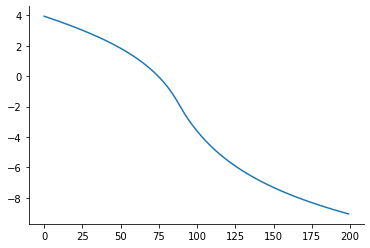

In [12]:
plt.plot(model_list[11][12]['v0'])

In [47]:
# Prepare ϕ_m
ϕ_m = np.zeros((n_model, len(y_grid_short)))
e_m = np.zeros((n_model, len(y_grid_short)))
for i in range(len(y_grid_tilde)):
    for j in range(n_model):
        ϕ_m[j, y_bar_lower_loc+i] = model_list[j][i]['v0'][y_bar_lower_loc+i]
        e_m[j, y_bar_lower_loc+i] = model_list[j][i]['e_tilde'][y_bar_lower_loc+i]

# Prepare v_guess
v_guess = np.average(np.array([model_list[0][-1]['v0'][:y_bar_upper_loc],
                               model_list[-1][-1]['v0'][:y_bar_upper_loc]]),
                     weights=np.array([0.5, 0.5]), axis=0)

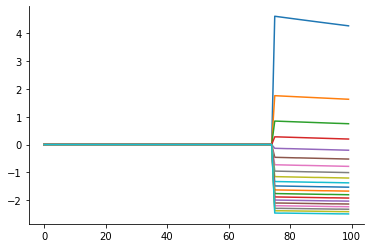

In [50]:
for i in range(ϕ_m.shape[0]):
    plt.plot(ϕ_m[i])

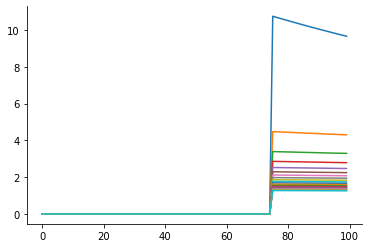

In [51]:
for i in range(ϕ_m.shape[0]):
    plt.plot(e_m[i])

In [14]:
ϕ_m.shape

(20, 100)

In [15]:
np.max(ϕ_m[11])

0.0

In [16]:
np.max(ϕ_m)

4.603582092905351

In [17]:
def ode_y_jump_intensity_approach(y_grid, model_paras=(), v0=None, ϵ=.5, tol=1e-8,
                                     max_iter=10_000, print_all=True):
    η, δ, θ, πc_o, σ_y, ξ_1m, ξ_2m, ξ_a, γ_1, γ_2, y_bar_lower, y_bar_upper, ϕ_i, πd_o, r0, r1, τ = model_paras
    Δ_y = y_grid[1] - y_grid[0]

    if v0 is None:
        v0 = - η * (y_grid + y_grid**2)

    d_Λ = γ_1 + γ_2*y_grid
    dd_Λ = γ_2

    πd = np.ones((len(πd_o), len(y_grid)))
    for i in range(πd.shape[0]):
        πd[i] = πd_o[i]
    πd_o = πd

    πc = np.ones((len(πc_o), len(y_grid)))
    θ_reshape = np.ones_like(πc)
    for i in range(πc.shape[0]):
        πc[i] = πc_o[i]
        θ_reshape[i] = θ[i]
    πc_o = πc.copy()
    θ = θ_reshape

    intensity = - r0 * (np.exp(- r1 / 2. * (y_grid-y_bar_lower)**2) - 1.) * (y_grid >= y_bar_lower)\
                + 0 * (y_grid < y_bar_lower)

    e_tilde = 0.
    
    count = 0
    error = 1.

    while error > tol and count < max_iter:
        v_old = v0.copy()
        e_tilde_old = e_tilde

        v0_dy = compute_derivatives(v0, 1, Δ_y, central_diff=False)
        v0_dyy = compute_derivatives(v0, 2, Δ_y)

        G = v0_dy + (η-1)/δ*d_Λ

        if σ_y == 0:
            e_tilde = -η/(G*np.sum(πc*θ, axis=0))
        else:
            temp = σ_y**2*(v0_dyy+(η-1.)/δ*dd_Λ-G**2/ξ_1m)
            root = np.sum(πc*θ, axis=0)**2*G**2 - 4*η*temp
            root[root<0] = 0.
            e_tilde = (-G*np.sum(πc*θ, axis=0) - np.sqrt(root)) / (2*temp)

        e_tilde[e_tilde<=0] = 1e-16
        e_tilde = e_tilde *.5 + e_tilde_old*.5
 
        log_πc_ratio = -G*e_tilde*θ/ξ_a
        πc_ratio = log_πc_ratio - np.max(log_πc_ratio, axis=0)
        πc = np.exp(πc_ratio) * πc_o
        πc = πc/np.sum(πc, axis=0)
        πc[πc<=0] = 1e-16        
        c_entropy = np.sum(πc*(np.log(πc)-np.log(πc_o)), axis=0)

#         g = np.exp(1./ξ_2m*(v0-ϕ_i))

#         A = np.ones_like(y_grid)*(-δ)
#         B = e_tilde * np.sum(πc*θ, axis=0)
#         C = .5 * σ_y**2 * e_tilde**2
#         D = η*np.log(e_tilde) - C*G**2/ξ_1m + (η-1)/δ*d_Λ*e_tilde*np.sum(πc*θ, axis=0)\
#             + .5*(η-1)/δ*dd_Λ*σ_y**2*e_tilde**2 + ξ_a*c_entropy\
#             - ξ_2m * intensity * (np.sum(πd_o * np.exp(-1./ξ_2m*ϕ_i), axis=0) - np.exp(-1./ξ_2m * v0)) \
#                 / np.exp(-1./ξ_2m * v0)

        g = np.exp(1. / ξ_2m * (v0 - ϕ_i))

        A = np.ones_like(y_grid)*(-δ) - intensity * np.sum(πd_o * g, axis=0)
        B = e_tilde * np.sum(πc*θ, axis=0)
        C = .5 * σ_y**2 * e_tilde**2
        D = η*np.log(e_tilde) - C*G**2/ξ_1m + (η-1)/δ*d_Λ*e_tilde*np.sum(πc*θ, axis=0)\
            + .5*(η-1)/δ*dd_Λ*σ_y**2*e_tilde**2 + ξ_a*c_entropy\
            + ξ_2m * intensity * np.sum(πd_o * (1 - g + g * np.log(g)), axis=0)\
            + intensity * np.sum(πd_o * g * ϕ_i, axis=0)

        v0 = false_transient_one_iteration_python(A, B, C, D, v0, ε, Δ_y, (0, 0), (False, False))

        rhs_error = A*v0 + B*v0_dy + C*v0_dyy + D
        rhs_error = np.max(abs(rhs_error))
        lhs_error = np.max(abs((v0 - v_old)/ϵ))
        error = lhs_error
        count += 1
        if print_all:
            print("Iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))

    h = -(v0_dy+(η-1)/δ*d_Λ)*e_tilde*σ_y/ξ_1m
    πd = g / np.sum(πd_o * g, axis=0) * πd_o
    
    
    print("Converged. Total iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))     
    res = {'v0': v0,
           'v0_dy': v0_dy,
           'v0_dyy': v0_dyy,
           'e_tilde': e_tilde,
           'y_grid': y_grid,
           'intensity': intensity,
           'πc': πc,
           'πd': πd,
           'g': g,
           'h': h,
           'θ': θ[:, 0],
           'σ_y': σ_y}
    return res

In [18]:
model_paras = (η, δ, θ, πc_o, σ_y, ξ_w, ξ_p, ξ_a, γ_1, γ_2, y_bar_lower, y_bar_upper, ϕ_m, πd_o, r0, r1, τ)
model_res = ode_y_jump_intensity_approach(y_grid_short, model_paras=model_paras, v0=v_guess, ϵ=1,
                                          tol=1e-8, max_iter=1000, print_all=True)

Iteration 1: LHS Error: 0.4866715564157438; RHS Error 0.4865805549599219
Iteration 2: LHS Error: 0.3806647470477649; RHS Error 0.3810758872430253
Iteration 3: LHS Error: 0.3064051390016739; RHS Error 0.3080355976349839
Iteration 4: LHS Error: 0.25267675327108424; RHS Error 0.25486228511848585
Iteration 5: LHS Error: 0.21334758122662412; RHS Error 0.21639931969478393
Iteration 6: LHS Error: 0.18402658910765574; RHS Error 0.18746354921408553
Iteration 7: LHS Error: 0.1620369807802282; RHS Error 0.16548608972932174
Iteration 8: LHS Error: 0.14484514068943133; RHS Error 0.14853614057385262
Iteration 9: LHS Error: 0.1312531174621776; RHS Error 0.13518373283106394
Iteration 10: LHS Error: 0.12048033318607704; RHS Error 0.12421894770992975
Iteration 11: LHS Error: 0.11128061118851551; RHS Error 0.11506779423865444
Iteration 12: LHS Error: 0.10382838185398163; RHS Error 0.10770666616862418
Iteration 13: LHS Error: 0.09726119784004583; RHS Error 0.101189689692331
Iteration 14: LHS Error: 0.0919

Iteration 140: LHS Error: 0.012124722546351219; RHS Error 0.011457882133392085
Iteration 141: LHS Error: 0.01199027893802862; RHS Error 0.011330987514938592
Iteration 142: LHS Error: 0.011846523273677967; RHS Error 0.011198039307333284
Iteration 143: LHS Error: 0.011714321344033607; RHS Error 0.011073311357918697
Iteration 144: LHS Error: 0.011574979332229063; RHS Error 0.010944345366434564
Iteration 145: LHS Error: 0.011445459322412699; RHS Error 0.010822244659132965
Iteration 146: LHS Error: 0.01130994189374368; RHS Error 0.010696733653632225
Iteration 147: LHS Error: 0.011183498942593406; RHS Error 0.010577603326918983
Iteration 148: LHS Error: 0.011051284916657966; RHS Error 0.010455079813389993
Iteration 149: LHS Error: 0.010928208988787436; RHS Error 0.010339170527865246
Iteration 150: LHS Error: 0.010798834431084536; RHS Error 0.010219217363759497
Iteration 151: LHS Error: 0.010679332549462295; RHS Error 0.010106706847072086
Iteration 152: LHS Error: 0.01055376316130685; RHS Err

Iteration 273: LHS Error: 0.00015219041786096454; RHS Error 0.003845825081782397
Iteration 274: LHS Error: 0.0001379754307340164; RHS Error 0.0038456875461073533
Iteration 275: LHS Error: 0.00012499754675676655; RHS Error 0.0038455653845747306
Iteration 276: LHS Error: 0.00011315949047041585; RHS Error 0.003845458113549858
Iteration 277: LHS Error: 0.00010237028509463286; RHS Error 0.0038453650978700366
Iteration 278: LHS Error: 9.25450327149413e-05; RHS Error 0.0038452855786207506
Iteration 279: LHS Error: 8.360467162216167e-05; RHS Error 0.0038452187009255278
Iteration 280: LHS Error: 7.547571747501536e-05; RHS Error 0.003845163540835819
Iteration 281: LHS Error: 6.80899937748336e-05; RHS Error 0.0038451191306356335
Iteration 282: LHS Error: 6.138435647073948e-05; RHS Error 0.0038450844819621376
Iteration 283: LHS Error: 5.530041665613439e-05; RHS Error 0.003845058606296275
Iteration 284: LHS Error: 4.978426460855445e-05; RHS Error 0.0038450405326102472
Iteration 285: LHS Error: 4.47

Iteration 406: LHS Error: 5.007633685494284e-07; RHS Error 0.0038536181903933483
Iteration 407: LHS Error: 4.934614916685121e-07; RHS Error 0.003853618122006311
Iteration 408: LHS Error: 4.860869227130138e-07; RHS Error 0.003853618039305845
Iteration 409: LHS Error: 4.786583844840209e-07; RHS Error 0.0038536179422073583
Iteration 410: LHS Error: 4.7135803171727275e-07; RHS Error 0.003853617830679534
Iteration 411: LHS Error: 4.6450352853000254e-07; RHS Error 0.0038536177048076135
Iteration 412: LHS Error: 4.576147967227939e-07; RHS Error 0.0038536175647447745
Iteration 413: LHS Error: 4.507174931056568e-07; RHS Error 0.0038536174107589925
Iteration 414: LHS Error: 4.438878864476692e-07; RHS Error 0.0038536172431955762
Iteration 415: LHS Error: 4.374979978294391e-07; RHS Error 0.003853617062546118
Iteration 416: LHS Error: 4.3110871894569414e-07; RHS Error 0.0038536168693784167
Iteration 417: LHS Error: 4.247385438915785e-07; RHS Error 0.00385361666440421
Iteration 418: LHS Error: 4.184

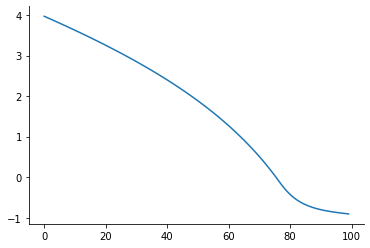

In [19]:
plt.plot(model_res['v0'])

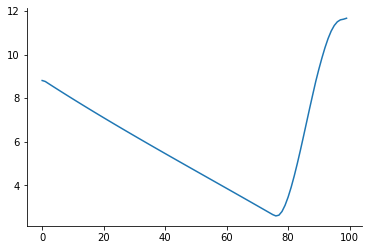

In [20]:
plt.plot(model_res['e_tilde'])

## Simulation

In [21]:
# Simulate capital process
# Capital and z parameters
α_k = -0.043
β_k = 0.04
σ_k = np.array([0.477*2, 0])/100.
β_z = 0.014*4
σ_z = np.array([0.011*2, 0.025*2])
α = 0.115
ioverk = 0.09
κ = 6.667


@njit(parallel=True)
def simulate_capital(α_k, β_k, σ_k, β_z, σ_z, ioverk, κ, Ws, k_start, N=100_000, T=100, dt=1.):
    var_z = dt*σ_z@σ_z/(1-(1-β_z*dt)**2)
    std_z = np.sqrt(var_z)

    time_periods = int(T/dt)
    z_path = np.zeros((N, time_periods+1))
    k_path = np.zeros((N, time_periods+1))
    for i in range(N):
        z0 = np.random.normal(0.,std_z)
        k0 = k_start
        z_path[i, 0] = z0
        k_path[i, 0] = k0
        for j in range(1, time_periods+1):
            k1 = k0 + (α_k + β_k*z0 + ioverk - κ/2.*ioverk**2 - σ_k@σ_k/2.)*dt + σ_k@Ws[i, j]*np.sqrt(dt)
            z1 = (1.-β_z*dt)*z0 + σ_z@Ws[i, j]*np.sqrt(dt)
            k_path[i, j] = k1
            z_path[i, j] = z1
            k0 = k1
            z0 = z1
    return k_path

T = 100
N = 1_000_000
dt = 1.
k_start = np.log(80/α)
η = .032
Ws = np.random.multivariate_normal(np.zeros(2), np.eye(2), (N, int(T/dt)))
logk_path = simulate_capital(α_k, β_k, σ_k, β_z, σ_z, ioverk, κ, Ws, k_start, N=N, T=T, dt=dt)
Kt = np.percentile(np.exp(logk_path), 50, axis=0)

In [22]:
e_grid_no_jump = model_res['e_tilde']
e_grid_jump_list = []
for i in range(n_model):
    temp = np.array([model['e_tilde'] for model in model_list[i]])
    e_grid_jump_list.append(temp)
e_grid_jump = np.array(e_grid_jump_list)

In [23]:
@njit
def simulation_one_path(y_grid_short, y_grid_long, y_grid_tilde, e_grid_no_jump, e_grid_jump,
                        θ, y0, y_bar_lower, r0, r1, τ, damage_prob, T=80):
    """
    y_grid : (N,) ndarray
    e_grid_no_jump : (N,) ndarray
    e_grid_jump : (3, M, N) ndarray
        e_grid[0, i], e_grid[1, i] and e_grid[2, i] are the emissions conditional
            on low, high and extreme damages when jump occurrs at y_grid_tilde[i].
    """
    yt = np.zeros(T+1)
    et = np.zeros(T+1)
    damage_states_t = np.zeros(T+1)
    jump_occurred = False
    e_grid_realized = e_grid_no_jump
    for i in range(T+1):
        if y0 > y_bar_lower and jump_occurred == False:
            intensity = - r0 * (np.exp(- r1 / 2. * (y0-y_bar_lower)**2) - 1.)
            jump_prob = τ * intensity
            realized_jump_state = np.random.multinomial(n=1, pvals=np.array([jump_prob, 1-jump_prob]))
            if np.array_equal(realized_jump_state, np.array([1, 0])):
                jump_occurred = True
                realized_damage_state = np.random.multinomial(n=1, pvals=damage_prob)
                loc = find_nearest_value(y_grid_tilde, y0)
                if np.array_equal(realized_damage_state, np.array([1, 0, 0])):
                    e_grid_realized = e_grid_jump[0, loc]
                    damage_states_t[i:] = 1
                elif np.array_equal(realized_damage_state, np.array([0, 1, 0])):
                    e_grid_realized = e_grid_jump[1, loc]
                    damage_states_t[i:] = 2
                else:
                    e_grid_realized = e_grid_jump[2, loc]
                    damage_states_t[i:] = 3
        if jump_occurred:
            et[i] = np.interp(y0, y_grid_long, e_grid_realized)
        else:
            et[i] = np.interp(y0, y_grid_short, e_grid_realized)
        yt[i] = y0
        y0 = y0 + et[i]*θ
    return et, yt, damage_states_t

@njit
def simulation_n_path(y_grid_short, y_grid_long, y_grid_tilde, e_grid_no_jump, e_grid_jump,
                      θ, y0, y_bar_lower, r0, r1, τ, damage_prob, T=80, N=10_000):
    yt_n_path = np.zeros((N, T+1))
    et_n_path = np.zeros((N, T+1))
    damage_states_t_n_path = np.zeros((N, T+1))
    for n in range(N):
        et, yt, damage_states_t = simulation_one_path(y_grid_short, y_grid_long, y_grid_tilde, e_grid_no_jump, e_grid_jump,
                                     θ, y0, y_bar_lower, r0, r1, τ, damage_prob, T=T)
        yt_n_path[n] = yt
        et_n_path[n] = et
        damage_states_t_n_path[n] = damage_states_t
    return et_n_path, yt_n_path, damage_states_t_n_path

In [24]:
et, yt, damage_states_t = simulation_n_path(y_grid_short, y_grid_long, y_grid_tilde, e_grid_no_jump, e_grid_jump,
                           np.mean(model_res['θ']), y0=1.1, y_bar_lower=y_bar_lower, r0=r0,
                           r1=r1, τ=τ, damage_prob=np.array([1./3, 1./3, 1./3]), T=120, N=1_000_000)

In [25]:
et_10 = np.percentile(et, 10, axis=0)
et_50 = np.percentile(et, 50, axis=0)
et_90 = np.percentile(et, 90, axis=0)

et_01 = np.percentile(et, 1, axis=0)
et_99 = np.percentile(et, 99, axis=0)

In [26]:
np.unique(et[:,120]).shape

(173,)

Text(0.5, 0, 'Years')

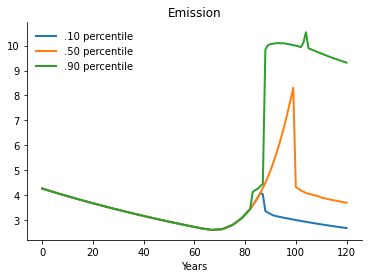

In [27]:
plt.plot(et_10, label='.10 percentile', linewidth=2.)
plt.plot(et_50, label='.50 percentile', linewidth=2.)
plt.plot(et_90, label='.90 percentile', linewidth=2.)
plt.legend(frameon=False)
plt.title('Emission')
plt.xlabel('Years')

## No jump plots

In [39]:
T = 111
et_no_jump, yt_no_jump, _, _ = simulation(model_res['y_grid'], model_res['e_tilde'], model_res['h'], model_res['g'],
                            θ=np.mean(model_res['θ']), y_start=1.1, T=T)

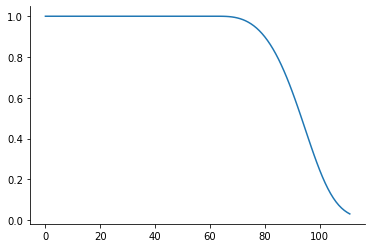

In [40]:
# Compute continuation probability
dt = 1./1
con_prob = np.ones(int(T/dt)+1)
time_periods = np.arange(0, T+dt, dt)
yt_no_jump_long = np.interp(time_periods, np.array(range(T+1)), yt_no_jump)
con_prob_sum = 0
for t in range(time_periods.shape[0]):
    y = yt_no_jump_long[t]
    if y >= y_bar_lower:
        intensity = - r0 * (np.exp(- r1 / 2. * (y-y_bar_lower)**2) - 1.)
        con_prob_sum += intensity * dt
        con_prob[t] = np.exp(-con_prob_sum)

# Plot continuation probability
plt.plot(time_periods, con_prob)

In [41]:
# Compute no jump probability
no_jump_prob = np.ones_like(yt_no_jump)
for t in range(no_jump_prob.shape[0]):
    y = yt_no_jump[t]
    if y > y_bar_lower:
        intensity = - r0 * (np.exp(- r1 / 2. * (y-y_bar_lower)**2) - 1.)
        no_jump_prob[t] = (1 - intensity*τ) * no_jump_prob[t-1]

In [42]:
# np.save('yt_03.npy', yt_no_jump)
# np.save('prob_03.npy', no_jump_prob)

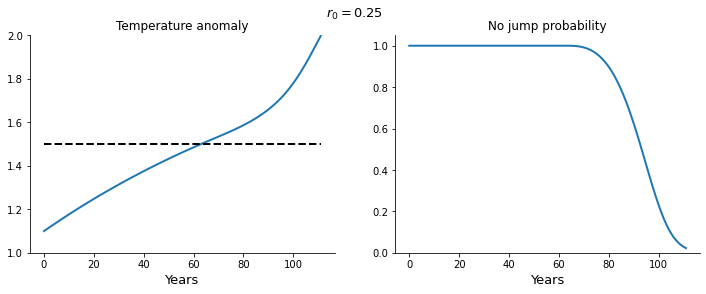

In [46]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
ax1.plot(yt_no_jump, linewidth=2.)
ax1.plot(np.ones_like(yt_no_jump)*1.5, linestyle='dashed', color='black', linewidth=2)
ax1.set_xlabel('Years', fontsize=13)
ax1.set_title(r'Temperature anomaly')
ax1.set_ylim(1, 2)

ax2.plot(no_jump_prob, linewidth=2.)
ax2.set_xlabel('Years', fontsize=13)
ax2.set_title(r'No jump probability')
ax2.set_ylim(0, 1.05)

fig.suptitle(r'$r_0=0.25$', fontsize=13)
fig.savefig('fig.pdf')

In [44]:
def compute_prob(array):
    array_unique = np.unique(array)
    prob = np.zeros_like(array_unique)
    for i, point in enumerate(array_unique):
        prob[i] = np.sum(array==point)/len(array)
    return array_unique, prob

## T = 60

In [45]:
(1-no_jump_prob[80])/3

0.0338497814824105

In [ ]:
# Compute probabilities
T_plot = 60
et_states, et_prob = compute_prob(et[:, T_plot])
Kt_fixed = Kt[T_plot]

et_no_jump = et[:, T_plot][damage_states_t[:, T_plot]==0]
et_low = et[:, T_plot][damage_states_t[:, T_plot]==1]
et_high = et[:, T_plot][damage_states_t[:, T_plot]==2]
et_extreme = et[:, T_plot][damage_states_t[:, T_plot]==3]

et_no_jump_states, et_no_jump_prob = compute_prob(et_no_jump)
et_low_states, et_low_prob = compute_prob(et_low)
et_high_states, et_high_prob = compute_prob(et_high)
et_extreme_states, et_extreme_prob = compute_prob(et_extreme)

yt_no_jump = yt[:, T_plot][damage_states_t[:, T_plot]==0]
yt_low = yt[:, T_plot][damage_states_t[:, T_plot]==1]
yt_high = yt[:, T_plot][damage_states_t[:, T_plot]==2]
yt_extreme = yt[:, T_plot][damage_states_t[:, T_plot]==3]

yt_no_jump_states, yt_no_jump_prob = compute_prob(yt_no_jump)
yt_low_states, yt_low_prob = compute_prob(yt_low)
yt_high_states, yt_high_prob = compute_prob(yt_high)
yt_extreme_states, yt_extreme_prob = compute_prob(yt_extreme)

In [ ]:
et_no_jump_states

In [ ]:
et_no_jump_states.shape, et_low_states.shape, et_high_states.shape, et_extreme_states.shape

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))
ax1.hist(et_low_states, weights=et_low_prob, bins=20, density=False)
ax1.set_ylabel('Probability', fontsize=13)

ax2.hist(et_high_states, weights=et_high_prob, bins=20, density=False)
ax2.set_ylabel('Probability', fontsize=13)

ax3.hist(et_extreme_states, weights=et_extreme_prob, bins=20, density=False)
ax3.set_ylabel('Probability', fontsize=13)

fig.suptitle(r'Figure 1.1: Histograms of emission conditional on low (left), high (middle) and extreme (right) damage; Year '+str(T_plot))
fig.savefig('fig_11.pdf')


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,4))
ax1.hist(η*(0.025)*Kt_fixed/((1.-η)*et_low_states)*1000, weights=et_low_prob, bins=20, density=False)
ax1.set_ylabel('Probability', fontsize=13)

ax2.hist(η*(0.025)*Kt_fixed/((1.-η)*et_high_states)*1000, weights=et_high_prob, bins=20, density=False)
ax2.set_ylabel('Probability', fontsize=13)

ax3.hist(η*(0.025)*Kt_fixed/((1.-η)*et_extreme_states)*1000, weights=et_extreme_prob, bins=20, density=False)
ax3.set_ylabel('Probability', fontsize=13)

fig.suptitle(r'Figure 1.2: Histograms of SCC conditional on low (left), high (middle) and extreme (right) damage; Year '+str(T_plot))
fig.savefig('fig_12.pdf')

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))
ax1.hist(yt_low_states, weights=et_low_prob, bins=20, density=False)
ax1.set_ylabel('Probability', fontsize=13)

ax2.hist(yt_high_states, weights=et_high_prob, bins=20, density=False)
ax2.set_ylabel('Probability', fontsize=13)

ax3.hist(yt_extreme_states, weights=et_extreme_prob, bins=20, density=False)
ax3.set_ylabel('Probability', fontsize=13)

fig.suptitle(r'Figure 1.3: Histograms of temperature anomaly conditional on low (left), high (middle) and extreme (right) damage; Year '+str(T_plot))
fig.savefig('fig_13.pdf')

In [ ]:
# Compute probabilities
T_plot = 70
et_states, et_prob = compute_prob(et[:, T_plot])
Kt_fixed = Kt[T_plot]

et_no_jump = et[:, T_plot][damage_states_t[:, T_plot]==0]
et_low = et[:, T_plot][damage_states_t[:, T_plot]==1]
et_high = et[:, T_plot][damage_states_t[:, T_plot]==2]
et_extreme = et[:, T_plot][damage_states_t[:, T_plot]==3]

et_no_jump_states, et_no_jump_prob = compute_prob(et_no_jump)
et_low_states, et_low_prob = compute_prob(et_low)
et_high_states, et_high_prob = compute_prob(et_high)
et_extreme_states, et_extreme_prob = compute_prob(et_extreme)

yt_no_jump = yt[:, T_plot][damage_states_t[:, T_plot]==0]
yt_low = yt[:, T_plot][damage_states_t[:, T_plot]==1]
yt_high = yt[:, T_plot][damage_states_t[:, T_plot]==2]
yt_extreme = yt[:, T_plot][damage_states_t[:, T_plot]==3]

yt_no_jump_states, yt_no_jump_prob = compute_prob(yt_no_jump)
yt_low_states, yt_low_prob = compute_prob(yt_low)
yt_high_states, yt_high_prob = compute_prob(yt_high)
yt_extreme_states, yt_extreme_prob = compute_prob(yt_extreme)

In [ ]:
et_no_jump_states.shape, et_low_states.shape, et_high_states.shape, et_extreme_states.shape

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))
ax1.hist(et_low_states, weights=et_low_prob, bins=20, density=False)
ax1.set_ylabel('Probability', fontsize=13)

ax2.hist(et_high_states, weights=et_high_prob, bins=20, density=False)
ax2.set_ylabel('Probability', fontsize=13)

ax3.hist(et_extreme_states, weights=et_extreme_prob, bins=20, density=False)
ax3.set_ylabel('Probability', fontsize=13)

fig.suptitle(r'Figure 2.1: Histograms of emission conditional on low (left), high (middle) and extreme (right) damage; Year '+str(T_plot))
fig.savefig('fig_21.pdf')


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,4))
ax1.hist(η*(0.025)*Kt_fixed/((1.-η)*et_low_states)*1000, weights=et_low_prob, bins=20, density=False)
ax1.set_ylabel('Probability', fontsize=13)

ax2.hist(η*(0.025)*Kt_fixed/((1.-η)*et_high_states)*1000, weights=et_high_prob, bins=20, density=False)
ax2.set_ylabel('Probability', fontsize=13)

ax3.hist(η*(0.025)*Kt_fixed/((1.-η)*et_extreme_states)*1000, weights=et_extreme_prob, bins=20, density=False)
ax3.set_ylabel('Probability', fontsize=13)

fig.suptitle(r'Figure 2.2: Histograms of SCC conditional on low (left), high (middle) and extreme (right) damage; Year '+str(T_plot))
fig.savefig('fig_22.pdf')

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))
ax1.hist(yt_low_states, weights=et_low_prob, bins=20, density=False)
ax1.set_ylabel('Probability', fontsize=13)

ax2.hist(yt_high_states, weights=et_high_prob, bins=20, density=False)
ax2.set_ylabel('Probability', fontsize=13)

ax3.hist(yt_extreme_states, weights=et_extreme_prob, bins=20, density=False)
ax3.set_ylabel('Probability', fontsize=13)

fig.suptitle(r'Figure 2.3: Histograms of temperature anomaly conditional on low (left), high (middle) and extreme (right) damage; Year '+str(T_plot))
fig.savefig('fig_23.pdf')

In [ ]:
# Compute probabilities
T_plot = 80
et_states, et_prob = compute_prob(et[:, T_plot])
Kt_fixed = Kt[T_plot]

et_no_jump = et[:, T_plot][damage_states_t[:, T_plot]==0]
et_low = et[:, T_plot][damage_states_t[:, T_plot]==1]
et_high = et[:, T_plot][damage_states_t[:, T_plot]==2]
et_extreme = et[:, T_plot][damage_states_t[:, T_plot]==3]

et_no_jump_states, et_no_jump_prob = compute_prob(et_no_jump)
et_low_states, et_low_prob = compute_prob(et_low)
et_high_states, et_high_prob = compute_prob(et_high)
et_extreme_states, et_extreme_prob = compute_prob(et_extreme)

yt_no_jump = yt[:, T_plot][damage_states_t[:, T_plot]==0]
yt_low = yt[:, T_plot][damage_states_t[:, T_plot]==1]
yt_high = yt[:, T_plot][damage_states_t[:, T_plot]==2]
yt_extreme = yt[:, T_plot][damage_states_t[:, T_plot]==3]

yt_no_jump_states, yt_no_jump_prob = compute_prob(yt_no_jump)
yt_low_states, yt_low_prob = compute_prob(yt_low)
yt_high_states, yt_high_prob = compute_prob(yt_high)
yt_extreme_states, yt_extreme_prob = compute_prob(yt_extreme)

In [ ]:
et_no_jump_states.shape, et_low_states.shape, et_high_states.shape, et_extreme_states.shape

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))
ax1.hist(et_low_states, weights=et_low_prob, bins=20, density=False)
ax1.set_ylabel('Probability', fontsize=13)

ax2.hist(et_high_states, weights=et_high_prob, bins=20, density=False)
ax2.set_ylabel('Probability', fontsize=13)

ax3.hist(et_extreme_states, weights=et_extreme_prob, bins=20, density=False)
ax3.set_ylabel('Probability', fontsize=13)

fig.suptitle(r'Figure 3.1: Histograms of emission conditional on low (left), high (middle) and extreme (right) damage; Year '+str(T_plot))
fig.savefig('fig_31.pdf')


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,4))
ax1.hist(η*(0.025)*Kt_fixed/((1.-η)*et_low_states)*1000, weights=et_low_prob, bins=20, density=False)
ax1.set_ylabel('Probability', fontsize=13)

ax2.hist(η*(0.025)*Kt_fixed/((1.-η)*et_high_states)*1000, weights=et_high_prob, bins=20, density=False)
ax2.set_ylabel('Probability', fontsize=13)

ax3.hist(η*(0.025)*Kt_fixed/((1.-η)*et_extreme_states)*1000, weights=et_extreme_prob, bins=20, density=False)
ax3.set_ylabel('Probability', fontsize=13)

fig.suptitle(r'Figure 3.2: Histograms of SCC conditional on low (left), high (middle) and extreme (right) damage; Year '+str(T_plot))
fig.savefig('fig_32.pdf')

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))
ax1.hist(yt_low_states, weights=et_low_prob, bins=20, density=False)
ax1.set_ylabel('Probability', fontsize=13)

ax2.hist(yt_high_states, weights=et_high_prob, bins=20, density=False)
ax2.set_ylabel('Probability', fontsize=13)

ax3.hist(yt_extreme_states, weights=et_extreme_prob, bins=20, density=False)
ax3.set_ylabel('Probability', fontsize=13)

fig.suptitle(r'Figure 3.3: Histograms of temperature anomaly conditional on low (left), high (middle) and extreme (right) damage; Year '+str(T_plot))
fig.savefig('fig_33.pdf')

In [ ]:
plt.figure()
plt.hist(et_states, weights=et_prob, bins=100, density=False)
plt.title('Figure 1: Emission histogram ('+str(T_after)+r' years after $y$ reaching 1.5)')
plt.ylabel('Probability')
# plt.savefig('fig_1.pdf')

plt.figure()
plt.hist(η*(0.025)*Kt_fixed/((1.-η)*et_states)*1000, weights=et_prob, bins=100, density=False)
plt.title(r'Figure 2: SCC histogram ('+str(T_after)+r' years after $y$ reaching 1.5)')
plt.ylabel('Probability')
# plt.savefig('fig_2.pdf')

In [ ]:
# Compute probabilities
T_after = 20
et_states, et_prob = compute_prob(et[:, 50+T_after])
Kt_fixed = Kt[50+T_after]

In [ ]:
plt.figure()
plt.hist(et_states, weights=et_prob, bins=100, density=False)
plt.title('Figure 3: Emission histogram ('+str(T_after)+r' years after $y$ reaching 1.5)')
plt.ylabel('Probability')
plt.savefig('fig_3.pdf')

plt.figure()
plt.hist(η*(0.025)*Kt_fixed/((1.-η)*et_states)*1000, weights=et_prob, bins=100, density=False)
plt.title(r'Figure 4: SCC histogram ('+str(T_after)+r' years after $y$ reaching 1.5)')
plt.ylabel('Probability')
plt.savefig('fig_4.pdf')

In [ ]:
# Compute probabilities
T_after = 20
et_states, et_prob = compute_prob(et[:, 50+T_after])
Kt_fixed = Kt[50+T_after]

In [ ]:
import pandas as pd
df = pd.DataFrame({'emission state': et_states,
              'SCC state': η*(0.025)*Kt_fixed/((1.-η)*et_states)*1000, 
              'probability': et_prob})
df[-30:]

In [ ]:
yt_no_jump[55], yt_no_jump[60], yt_no_jump[65], yt_no_jump[70]

In [ ]:
yt_no_jump[80]

## Old plots

In [ ]:
plt.plot(y_grid_short[40:], model_res['πd'][0][40:], label='low damage')
plt.plot(y_grid_short[40:], model_res['πd'][1][40:], label='high damage')
plt.plot(y_grid_short[40:], model_res['πd'][2][40:], label='extreme damage')
plt.legend(frameon=False)
plt.ylim(0, 1)

In [ ]:
plt.plot(y_grid_short, model_res['e_tilde'])
plt.title('Figure 1: Emission')
plt.xlabel('y')
plt.savefig('fig_1.pdf')

In [ ]:
plt.plot(y_grid_short, model_res['v0_dy'])
plt.title(r'Figure 2: $\frac{d\phi}{dy}(y)$')
plt.xlabel('y')
plt.savefig('fig_2.pdf')

In [ ]:
plt.plot(y_grid_short, model_res['intensity'])
plt.title('Figure 3: Intensity')
plt.xlabel('y')
plt.savefig('fig_3.pdf')

In [ ]:
plt.plot(y_grid_short, model_res['v0'])
plt.title(r'Figure 4: Value function $\phi(y)$')
plt.xlabel('y')
plt.savefig('fig_4.pdf')

In [ ]:
et, yt, ht, gt = simulation(model_res['y_grid'], model_res['e_tilde'], model_res['h'], model_res['g'],
                            θ=np.mean(model_res['θ']), y_start=1.1, T=89)

In [ ]:
plt.plot(et)

In [ ]:
# Compute model high/extreme at 1.6, 1.8, 2.0
model_args_high_new = []
model_args_extreme_new = []

for y_jump in [1.6, 1.8, 2.0]:
    model_paras_high = (η, δ, θ, πc_o, σ_y, ξ_w, ξ_a, γ_1, γ_2, γ_2p[1], y_jump)
    model_paras_extreme = (η, δ, θ, πc_o, σ_y, ξ_w, ξ_a, γ_1, γ_2, γ_2p[2], y_jump)
    model_args_high_new.append((np.arange(0., y_bar_upper*2, .01), model_paras_high, None, ϵ, 1e-8, 5000, False))
    model_args_extreme_new.append((np.arange(0., y_bar_upper*2, .01), model_paras_extreme, None, ϵ, 1e-8, 5000, False))

print('----- Solving high damage models -----')
model_high_list_new = ode_y_parallel(model_args_high_new)
print('----- Solving extreme damage models -----')
model_extreme_list_new = ode_y_parallel(model_args_extreme_new)

In [ ]:
et_low, _, _, _ = simulation(model_low['y_grid'], model_low['e_tilde'], model_low['h'],
                                 np.array([np.zeros_like(model_low['h']), np.zeros_like(model_low['h'])]),
                                 θ=np.mean(model_res['θ']), y_start=1.1, T=89)

In [ ]:
et_high_16, _, _, _ = simulation(model_high_list_new[0]['y_grid'], model_high_list_new[0]['e_tilde'], model_high_list_new[0]['h'],
                                 np.array([np.zeros_like(model_high_list_new[0]['h']), np.zeros_like(model_high_list_new[0]['h'])]),
                                 θ=np.mean(model_res['θ']), y_start=1.1, T=89)

In [ ]:
et_high_18, _, _, _ = simulation(model_high_list_new[1]['y_grid'], model_high_list_new[1]['e_tilde'], model_high_list_new[1]['h'],
                                 np.array([np.zeros_like(model_high_list_new[1]['h']), np.zeros_like(model_high_list_new[1]['h'])]),
                                 θ=np.mean(model_res['θ']), y_start=1.1, T=89)

In [ ]:
et_high_20, _, _, _ = simulation(model_high_list_new[2]['y_grid'], model_high_list_new[2]['e_tilde'], model_high_list_new[2]['h'],
                                 np.array([np.zeros_like(model_high_list_new[2]['h']), np.zeros_like(model_high_list_new[2]['h'])]),
                                 θ=np.mean(model_res['θ']), y_start=1.1, T=89)

In [ ]:
et_extreme_16, _, _, _ = simulation(model_extreme_list_new[0]['y_grid'], model_extreme_list_new[0]['e_tilde'], model_extreme_list_new[0]['h'],
                                 np.array([np.zeros_like(model_extreme_list_new[0]['h']), np.zeros_like(model_extreme_list_new[0]['h'])]),
                                 θ=np.mean(model_res['θ']), y_start=1.1, T=89)

In [ ]:
et_extreme_18, _, _, _ = simulation(model_extreme_list_new[1]['y_grid'], model_extreme_list_new[1]['e_tilde'], model_extreme_list_new[1]['h'],
                                 np.array([np.zeros_like(model_extreme_list_new[1]['h']), np.zeros_like(model_extreme_list_new[1]['h'])]),
                                 θ=np.mean(model_res['θ']), y_start=1.1, T=89)

In [ ]:
et_extreme_20, _, _, _ = simulation(model_extreme_list_new[2]['y_grid'], model_extreme_list_new[2]['e_tilde'], model_extreme_list_new[2]['h'],
                                 np.array([np.zeros_like(model_extreme_list_new[2]['h']), np.zeros_like(model_extreme_list_new[2]['h'])]),
                                 θ=np.mean(model_res['θ']), y_start=1.1, T=89)

In [ ]:
plt.plot(et_low)
plt.plot(et_high_16)
plt.plot(et_extreme_16)

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,5))
ax1.plot(et, label='with jump uncertainty', linewidth=2.5)
ax1.set_xlabel('Years', fontsize=13)
ax1.set_ylabel('Emission', fontsize=13)
ax1.legend(frameon=False, loc = 'upper left')
ax1.set_ylim(0, 16)
ax1.set_xlim(0, 90)

ax2.plot(et_low, label='low damage', linewidth=2.5)
ax2.plot(et_high_16, label=r'high damage, jump at $\bar{y} = 1.6$', linewidth=2.5)
ax2.plot(et_extreme_16, label=r'extreme damage, jump at $\bar{y} = 1.6$', linewidth=2.5)
ax2.set_xlabel('Years', fontsize=13)
ax2.set_ylabel('Emission', fontsize=13)
ax2.legend(frameon=False, loc = 'upper left')
ax2.set_ylim(0, 16)
ax2.set_xlim(0, 90)

ax3.plot(et_low, label='low damage', linewidth=2.5)
ax3.plot(et_high_20, label=r'high damage, jump at $\bar{y} = 2.0$', linewidth=2.5)
ax3.plot(et_extreme_20, label=r'extreme damage, jump at $\bar{y} = 2.0$', linewidth=2.5)
ax3.set_xlabel('Years', fontsize=13)
ax3.set_ylabel('Emission', fontsize=13)
ax3.legend(frameon=False, loc = 'upper left')
ax3.set_ylim(0, 16)
ax3.set_xlim(0, 90)

fig.suptitle('Figure 1: Emission', fontsize=13)
fig.savefig('fig_1.pdf')

In [ ]:
# Simulate capital process
# Capital and z parameters
α_k = -0.043
β_k = 0.04
σ_k = np.array([0.477*2, 0])/100.
β_z = 0.014*4
σ_z = np.array([0.011*2, 0.025*2])
α = 0.115
ioverk = 0.09
κ = 6.667


@njit(parallel=True)
def simulate_capital(α_k, β_k, σ_k, β_z, σ_z, ioverk, κ, Ws, k_start, N=100_000, T=100, dt=1.):
    var_z = dt*σ_z@σ_z/(1-(1-β_z*dt)**2)
    std_z = np.sqrt(var_z)

    time_periods = int(T/dt)
    z_path = np.zeros((N, time_periods+1))
    k_path = np.zeros((N, time_periods+1))
    for i in range(N):
        z0 = np.random.normal(0.,std_z)
        k0 = k_start
        z_path[i, 0] = z0
        k_path[i, 0] = k0
        for j in range(1, time_periods+1):
            k1 = k0 + (α_k + β_k*z0 + ioverk - κ/2.*ioverk**2 - σ_k@σ_k/2.)*dt + σ_k@Ws[i, j]*np.sqrt(dt)
            z1 = (1.-β_z*dt)*z0 + σ_z@Ws[i, j]*np.sqrt(dt)
            k_path[i, j] = k1
            z_path[i, j] = z1
            k0 = k1
            z0 = z1
    return k_path

T = 100
N = 1_000_000
dt = 1.
k_start = np.log(80/α)
η = .032
Ws = np.random.multivariate_normal(np.zeros(2), np.eye(2), (N, int(T/dt)))
logk_path = simulate_capital(α_k, β_k, σ_k, β_z, σ_z, ioverk, κ, Ws, k_start, N=N, T=T, dt=dt)
Kt = np.percentile(np.exp(logk_path), 50, axis=0)

In [ ]:
SCC = η*(0.025)*Kt/((1.-η)*et) * 1000
SCC_low = η*(0.025)*Kt/((1.-η)*et_low) * 1000
SCC_high_16 = η*(0.025)*Kt/((1.-η)*et_high_16) * 1000
SCC_high_18 = η*(0.025)*Kt/((1.-η)*et_high_18) * 1000
SCC_high_20 = η*(0.025)*Kt/((1.-η)*et_high_20) * 1000
SCC_extreme_16 = η*(0.025)*Kt/((1.-η)*et_extreme_16) * 1000
SCC_extreme_18 = η*(0.025)*Kt/((1.-η)*et_extreme_18) * 1000
SCC_extreme_20 = η*(0.025)*Kt/((1.-η)*et_extreme_20) * 1000

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,5))
ax1.plot(SCC, label='with jump uncertainty', linewidth=2.5)
ax1.set_xlabel('Years', fontsize=13)
ax1.set_ylabel('SCC', fontsize=13)
ax1.legend(frameon=False, loc = 'upper left')
ax1.set_ylim(0, 2000)
ax1.set_xlim(0, 90)

ax2.plot(SCC_low, label='low damage', linewidth=2.5)
ax2.plot(SCC_high_16, label=r'high damage, jump at $\bar{y} = 1.6$', linewidth=2.5)
ax2.plot(SCC_extreme_16, label=r'extreme damage, jump at $\bar{y} = 1.6$', linewidth=2.5)
ax2.set_xlabel('Years', fontsize=13)
ax2.set_ylabel('SCC', fontsize=13)
ax2.legend(frameon=False, loc = 'upper left')
ax2.set_ylim(0, 2000)
ax2.set_xlim(0, 90)

ax3.plot(SCC_low, label='low damage', linewidth=2.5)
ax3.plot(SCC_high_20, label=r'high damage, jump at $\bar{y} = 2.0$', linewidth=2.5)
ax3.plot(SCC_extreme_20, label=r'extreme damage, jump at $\bar{y} = 2.0$', linewidth=2.5)
ax3.set_xlabel('Years', fontsize=13)
ax3.set_ylabel('SCC', fontsize=13)
ax3.legend(frameon=False, loc = 'upper left')
ax3.set_ylim(0, 2000)
ax3.set_xlim(0, 90)

fig.suptitle('Figure 2: SCC', fontsize=13)
fig.savefig('fig_2.pdf')